In [14]:
# gtx5070ti를 지원하는 cuda12.8버전 지정 설치
#pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

In [15]:
# import torch

# if torch.cuda.is_available():
#     print("GPU is available!")
#     print(f"Device name: {torch.cuda.get_device_name(0)}")
# else:
#     print("GPU is not available.")

In [16]:
# 기본 환경 설정 및 데이터 준비

# 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# GPU 호환성 문제로 CPU 사용을 고정
device = torch.device("cpu")
print(f"Using device: {device}")

# 하이퍼파라미터 설정
batch_size = 64
learning_rate = 0.001
epochs = 10

# 데이터 전처리 및 로더 정의
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using device: cpu


In [17]:
# 2.모델 정의 및 학습/평가 함수

# 신경망 모델 정의 (CNN 버전)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=7*7*32, out_features=10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 7*7*32)
        x = self.fc1(x)
        return x

# 모델 학습 함수
def train_model(model, device, train_loader, optimizer, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

# 모델 평가 함수
def evaluate_model(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n')

# 예측 시각화 함수
def predict_and_visualize(model, test_loader):
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    fig = plt.figure(figsize=(12, 6))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        img = np.squeeze(images[i].numpy())
        ax.imshow(img, cmap='gray')

        title_color = "green" if predicted[i].item() == labels[i].item() else "red"
        ax.set_title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}", color=title_color)

    plt.tight_layout()
    plt.show()

--- Epoch 1/10 ---
Train Epoch: [0/60000 (0%)]	Loss: 2.324095
Train Epoch: [6400/60000 (11%)]	Loss: 0.153428
Train Epoch: [12800/60000 (21%)]	Loss: 0.159583
Train Epoch: [19200/60000 (32%)]	Loss: 0.196975
Train Epoch: [25600/60000 (43%)]	Loss: 0.184914
Train Epoch: [32000/60000 (53%)]	Loss: 0.109264
Train Epoch: [38400/60000 (64%)]	Loss: 0.188012
Train Epoch: [44800/60000 (75%)]	Loss: 0.074635
Train Epoch: [51200/60000 (85%)]	Loss: 0.037061
Train Epoch: [57600/60000 (96%)]	Loss: 0.013539

Test set: Average loss: 0.0009, Accuracy: 9800/10000 (98%)

--- Epoch 2/10 ---
Train Epoch: [0/60000 (0%)]	Loss: 0.052744
Train Epoch: [6400/60000 (11%)]	Loss: 0.045138
Train Epoch: [12800/60000 (21%)]	Loss: 0.042020
Train Epoch: [19200/60000 (32%)]	Loss: 0.047243
Train Epoch: [25600/60000 (43%)]	Loss: 0.142931
Train Epoch: [32000/60000 (53%)]	Loss: 0.037039
Train Epoch: [38400/60000 (64%)]	Loss: 0.035472
Train Epoch: [44800/60000 (75%)]	Loss: 0.059126
Train Epoch: [51200/60000 (85%)]	Loss: 0.133936
T

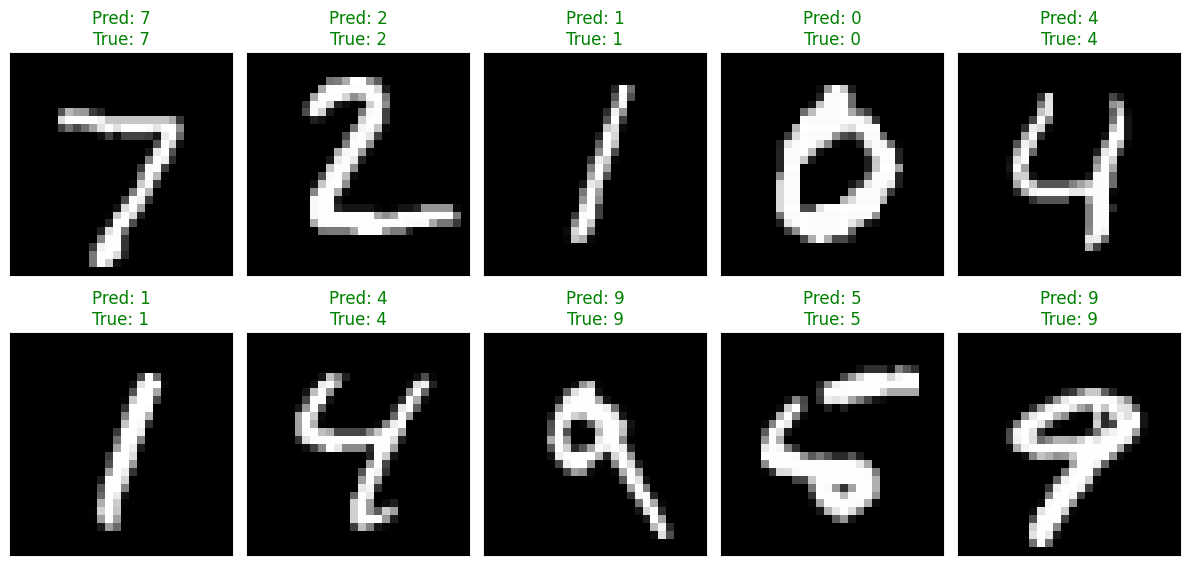

In [18]:
# 3.메인 실행 및 시각화

# 모델, 손실 함수, 옵티마이저 설정
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 모델 학습 및 평가
for epoch in range(1, epochs + 1):
    print(f"--- Epoch {epoch}/{epochs} ---")
    train_model(model, device, train_loader, optimizer, criterion)
    evaluate_model(model, device, test_loader, criterion)

# 학습된 모델 저장
torch.save(model.state_dict(), "mnist_cnn_model.pth")
print("\nModel successfully trained and saved to mnist_cnn_model.pth")

# 저장된 모델 불러와서 예측 시각화
print("\n--- Saved model loaded for visualization ---")
loaded_model = CNN()
loaded_model.load_state_dict(torch.load("mnist_cnn_model.pth"))
loaded_model.eval()
predict_and_visualize(loaded_model, test_loader)